In [175]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from mpl_toolkits.mplot3d import axes3d
import time
import math
import numpy as np
from scipy.special import eval_hermite
import random
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
import numpy.linalg as npl
from numba import jit, cuda
import numba
from scipy import constants
import pandas as pd

In [99]:
#Definición Constantes Naturales
hbar=constants.hbar #in J
me=constants.m_e # in Kg
e=constants.e # in C
a_0=constants.physical_constants['Bohr radius'][0] # in m
a_0A=a_0*1e10 # in Angstrom

In [100]:
RyJ=hbar**2/(2*me*a_0**2)     #in J
Ry=RyJ/e                    #in ev

In [213]:
a_0,a_0A

(5.29177210903e-11, 0.529177210903)

In [101]:
#Definición de Constantes Globales
Dd=10.47403700925231306*e # J 10.47403700925231306
Bd=0.0153e11 # m-1
wod=np.sqrt(2*Dd*Bd**2/me)

In [102]:
wod

2936798703460258.5

In [103]:
wo=wod*hbar/(RyJ)
wo

0.14207552708221846

In [104]:
D=Dd/RyJ
B=Bd*a_0
lim=80
k=10 # Numero de eigenstates
N=500

In [105]:
#Definicion de potenciales en 1D
def Vmp(x):
    return D*(1-np.exp(-B*x))**2
def Vqho(x):
    return 0.25*(wo**2)*(x**2)

In [106]:
x = np.linspace(-lim ,lim ,N)
Z=Vmp(x)
Zh=Vqho(x)

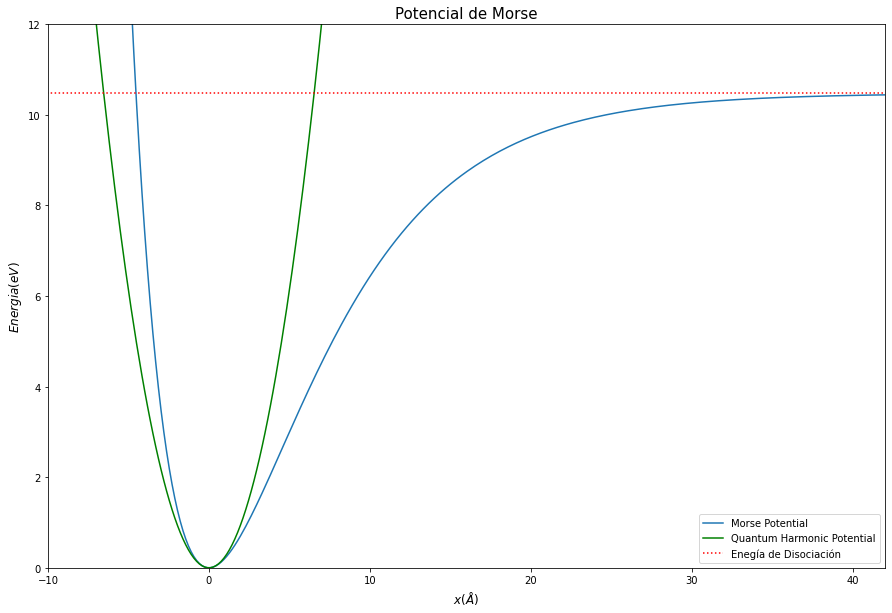

In [107]:
fig = plt.figure(figsize=(15,10))
plt.plot(x*a_0A,Z*Ry,label="Morse Potential")
plt.title('Potencial de Morse', fontsize=15)
plt.plot(x*a_0A,Zh*Ry,color='g',label="Quantum Harmonic Potential")
plt.axhline(y = Dd/e,xmin=-2, color = 'r', linestyle = ':',label='Enegía de Disociación')
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$Energia(eV)$',fontsize=12)
plt.legend(loc='lower right')
plt.ylim(0,12)
plt.xlim(-10,42)
plt.show() 

In [108]:
def HamiltonianHO(x):
    dx=2*lim/N
    T = (-1)*diags([-2., 1., 1.], [0,-1, 1], shape=(N, N))/dx**2
    V_vec=Vqho(x)
    V=diags([V_vec], [0])
    return (T+V)

In [109]:
eigenenergies, eigenfunctions= eigsh(HamiltonianHO(x),which='SM',k=N-1)

In [110]:
hbar*wod*0.5/e

0.966518010887731

In [111]:
eigenenergies[0:10]*Ry

array([ 0.96801354,  2.90315704,  4.83653218,  6.76813652,  8.69796762,
       10.62602302, 12.55230026, 14.47679686, 16.39951032, 18.32043814])

In [112]:
def psi(n,x):
    psi=eigenfunctions[:,n]
    return psi

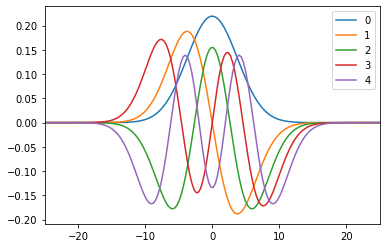

In [113]:
for i in range(5):
    plt.plot(x,psi(i,x),label=i)
    plt.legend()
    plt.xlim(-25,25)

In [114]:
def energy(f,H):
    rho =  np.outer(f, np.conj(f))
    expectation = np.trace(rho@H)
    return expectation

In [115]:
def sanduche(g,H,f):
    expectation=np.conj(g)@H@f
    return expectation

In [116]:
def EHO(n):
    return (hbar*wod*(n+0.5)/e)
EHO(0)

0.966518010887731

In [117]:
def Ene(n):
    return (hbar*wod*(n+0.5)/e) +(53/192)*2*B**2 
Ene(2)

4.836209064280081

In [118]:
def Ene1(n):
    return (hbar*wod*(n+0.5)/e) + (53/192)*2*B**2 +(13/16)*2*B**2*((n+0.5)**2)
Ene1(4)

8.917987751020885

In [119]:
def ER(n):
    return (hbar*wod*(n+0.5)/e) - (hbar**2*wod**2/(4*Dd*e))*(n+0.5)**2
ER(4)

6.89260770300893

In [174]:
def ErrorRelativo(ValorReal,ValorExperimental):
    return abs(ValorReal-ValorExperimental)*100/ValorReal

# Metodo de Perturbaciones

In [120]:
def Hp(x):
    P_vec=-D*B**3*x**3+(7*D*B**4*x**4/12)-(x**5*B**5*D/4)+((31/360)*D*B**6*x**6)-(1/40)*(D*B**7*x**7)+(127/20160)*(D*B**8*x**8)
    P=diags([P_vec], [0])
    return P

In [123]:
def energycorrection(x,n,l):
    sum=0
    sum2=0
    sum3=0
    E0=(hbar*wod*(n+0.5)/e)
    E1=energy(psi(n,x),Hp(x))
    for v in range(l+1):
      if v!=n:
         sum+=abs(np.conj(psi(v,x))@Hp(x)@psi(n,x))**2/(EHO(n)-EHO(v))
    E2=sum
    for k in range(l+1):
       for m in range(l+1):
          if k!=n and m!=n and k!=m:
             sum2+=(sanduche(psi(n,x),Hp(x),psi(m,x))*sanduche(psi(m,x),Hp(x),psi(k,x))*sanduche(psi(k,x),Hp(x),psi(n,x)))/((EHO(n)-EHO(m))*(EHO(n)-EHO(k)))
    for m in range(l+1):
       if m!=n:
         sum3+=abs(np.conj(psi(n,x))@Hp(x)@psi(m,x))**2/(EHO(n)-EHO(m))**2
    E3=sum2-(sanduche(psi(n,x),Hp(x),psi(n,x)))*sum3
    return E0+E1+E2+E3

In [124]:
def psicorrection(x,n,l):
    sum=0
    sum2=0
    sum3=0
    psin0=psi(n,x)
    for v in range(l+1):
      if v!=n:
         sum+=((sanduche(psi(v,x),Hp(x),psi(n,x)))/(EHO(n)-EHO(v)))*psi(v,x)
    for k in range(l+1):
       for m in range(l+1):
          if k!=n and m!=n and k!=m:
             sum2+=(((sanduche(psi(k,x),Hp(x),psi(m,x))*sanduche(psi(m,x),Hp(x),psi(n,x)))/((EHO(n)-EHO(k))*(EHO(n)-EHO(m))))-((sanduche(psi(n,x),Hp(x),psi(n,n))*sanduche(psi(k,n),Hp(x),psi(n,x)))/(EHO(n)-EHO(k))**2))*psi(k,x)
    for m in range(l+1):
       if m!=n:
         sum3+=(sanduche(psi(n,x),Hp(x),psi(m,x))*sanduche(psi(m,x),Hp(x),psi(n,x)))*psi(n,x)/(EHO(m)-EHO(n))**2
    psin1=sum
    psin2=sum2-0.5*sum3
    psin=psin0+psin1+psin2
    return psin/npl.norm(psin)

## Cálculo de Energías

In [125]:
cont=1
Energies=[energycorrection(x,0,N-2)]
while Energies[-1]<=(Dd/e):
    Energies.append(energycorrection(x,cont,N-2))
    cont+=1
Energies.remove(Energies[-1])

In [126]:
EnergiesHO=[]
for i in range(len(Energies)):
    EnergiesHO.append(EHO(i))

In [156]:
EnergiesAn=[]
for i in range(len(Energies)):
    EnergiesAn.append(Ene1(i))

In [157]:
EnergiesReal=[]
for i in range(len(Energies)):
    EnergiesReal.append(ER(i))

In [128]:
Dg,Bg=Dd/e,B/a_0A
print(Dg,Bg)

10.474037009252314 0.153


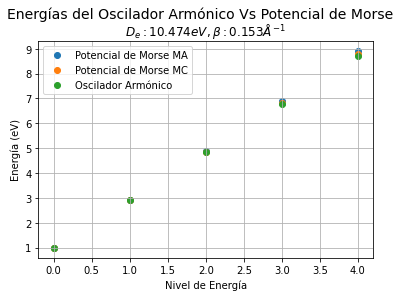

In [129]:
EnergyLevel=[i for i in range(len(Energies))]
plt.scatter(EnergyLevel,EnergiesAn, label='Potencial de Morse MA')
plt.scatter(EnergyLevel,Energies, label='Potencial de Morse MC')
plt.scatter(EnergyLevel,EnergiesHO,label='Oscilador Armónico')
plt.suptitle('Energías del Oscilador Armónico Vs Potencial de Morse', fontsize=14,y=1)
plt.title(r'$D_{e}: 10.474 eV, \beta: 0.153 \AA^{-1}$',y=1)
plt.ylabel('Energía (eV)')
plt.xlabel('Nivel de Energía')
plt.legend()
plt.grid()
plt.show()

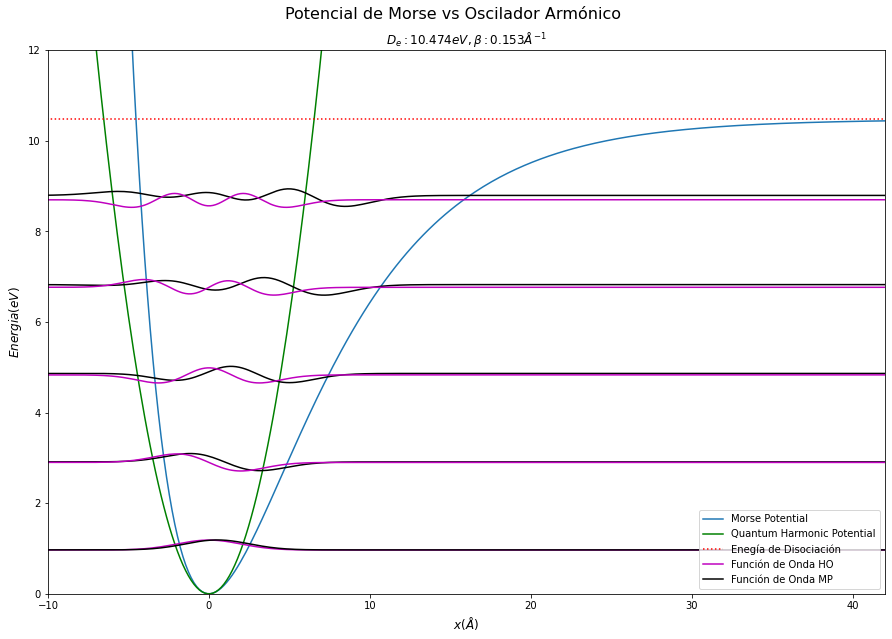

In [130]:
fig = plt.figure(figsize=(15,10))
plt.plot(x*a_0A,Z*Ry,label="Morse Potential")
plt.suptitle('Potencial de Morse vs Oscilador Armónico', fontsize=16,y=0.94)
plt.title(r'$D_{e}: 10.474 eV, \beta: 0.153 \AA^{-1}$',y=1,fontsize=12)
plt.plot(x*a_0A,Zh*Ry,color='g',label="Quantum Harmonic Potential")
plt.axhline(y = Dd/e,xmin=-2, color = 'r', linestyle = ':',label='Enegía de Disociación')
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$Energia(eV)$',fontsize=12)
plt.plot(x*a_0A,psi(0,x)+EnergiesHO[0],'m',label='Función de Onda HO')
plt.plot(x*a_0A+0.5,psicorrection(x,0,100)+Energies[0],'k',label="Función de Onda MP")
plt.plot(1.1*x*a_0A+0.9,psicorrection(x,1,100)+Energies[1],'k')
plt.plot(1.15*x*a_0A+1.2,psicorrection(x,2,100)+Energies[2],'k')
plt.plot(1.3*x*a_0A+1.6,psicorrection(x,3,100)+Energies[3],'k')
plt.plot(1.3*x*a_0A+1.9,psicorrection(x,4,100)+Energies[4],'k')
for i in range(1,len(Energies)):
    plt.plot(x*a_0A,psi(i,x)+EnergiesHO[i],'m')
plt.ylim(0,12)
plt.xlim(-10,42)
plt.legend(loc='lower right')
plt.show() 

In [131]:
def Hamiltonianmp(x):
    dx=2*lim/N
    T = (-1)*diags([-2., 1., 1.], [0,-1, 1], shape=(N, N))/dx**2
    V_vec=Vmp(x)
    V=diags([V_vec], [0])
    return (T+V)

In [147]:
eigenenergiesmp, eigenfunctionsmp= eigsh(Hamiltonianmp(x),which='SM',k=N-1)

In [148]:
eigenenergiesmp[0:10]*Ry

array([ 0.945654  ,  2.70214351,  4.27885233,  5.67635434,  6.89510369,
        7.93543466,  8.79756156,  9.48157846,  9.98746143, 10.31685747])

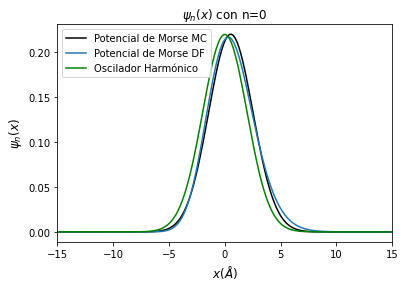

In [149]:
plt.plot(x*a_0A+0.5,psicorrection(x,0,100),'k',label="Potencial de Morse MC")
plt.plot(x*a_0A,eigenfunctionsmp[:,0], label='Potencial de Morse DF')
plt.plot(x*a_0A,psi(0,x),'g',label='Oscilador Harmónico')
plt.xlim(-15,15)
plt.title(r'$\psi_{n}(x)$'+ ' con n=' + str(0))
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$\psi_{n}(x)$',fontsize=12)
plt.legend()
plt.show()

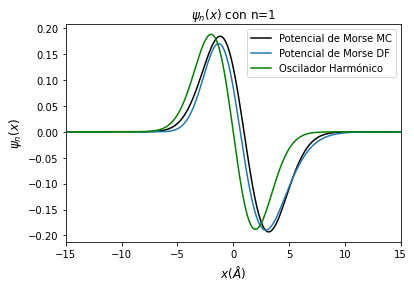

In [167]:
plt.plot(1.1*x*a_0A+0.9,psicorrection(x,1,100),'k',label="Potencial de Morse MC")
plt.plot(x*a_0A,-1*eigenfunctionsmp[:,1], label='Potencial de Morse DF')
plt.plot(x*a_0A,psi(1,x),'g',label='Oscilador Harmónico')
plt.xlim(-15,15)
plt.title(r'$\psi_{n}(x)$'+ ' con n=' + str(1))
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$\psi_{n}(x)$',fontsize=12)
plt.legend()
plt.show()

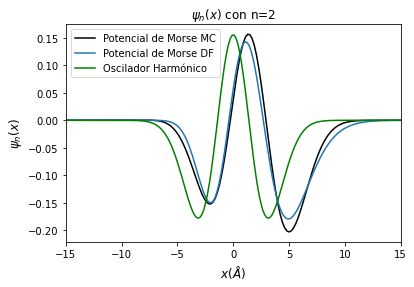

In [170]:
plt.plot(1.15*x*a_0A+1.2,psicorrection(x,2,100),'k',label="Potencial de Morse MC")
plt.plot(x*a_0A,1*eigenfunctionsmp[:,2], label='Potencial de Morse DF')
plt.plot(x*a_0A,psi(2,x),'g',label='Oscilador Harmónico')
plt.title(r'$\psi_{n}(x)$'+ ' con n=' + str(2))
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$\psi_{n}(x)$',fontsize=12)
plt.legend()
plt.xlim(-15,15)
plt.legend()
plt.show()

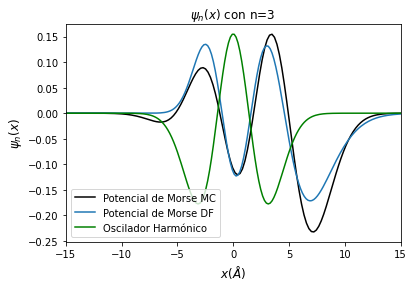

In [172]:
plt.plot(1.3*x*a_0A+1.6,psicorrection(x,3,100),'k',label="Potencial de Morse MC")
plt.plot(x*a_0A,-1*eigenfunctionsmp[:,3], label='Potencial de Morse DF')
plt.plot(x*a_0A,psi(2,x),'g',label='Oscilador Harmónico')
plt.title(r'$\psi_{n}(x)$'+ ' con n=' + str(3))
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$\psi_{n}(x)$',fontsize=12)
plt.legend()
plt.xlim(-15,15)
plt.legend()
plt.show()

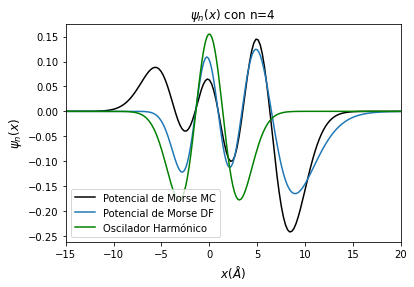

In [166]:
plt.plot(1.3*x*a_0A+1.9,psicorrection(x,4,100),'k',label="Potencial de Morse MC")
plt.plot(x*a_0A,eigenfunctionsmp[:,4], label='Potencial de Morse DF')
plt.plot(x*a_0A,psi(2,x),'g',label='Oscilador Harmónico')
plt.title(r'$\psi_{n}(x)$'+ ' con n=' + str(4))
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$\psi_{n}(x)$',fontsize=12)
plt.legend()
plt.xlim(-15,20)
plt.legend()
plt.show()

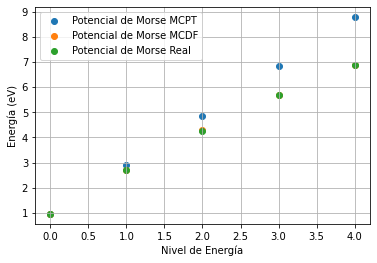

In [173]:
EnergyLevel=[i for i in range(len(Energies))]
plt.scatter(EnergyLevel,Energies, label='Potencial de Morse MCPT')
plt.scatter(EnergyLevel,eigenenergiesmp[0:5]*Ry, label='Potencial de Morse MCDF')
plt.scatter(EnergyLevel,EnergiesReal, label='Potencial de Morse Real')
plt.ylabel('Energía (eV)')
plt.xlabel('Nivel de Energía')
plt.grid()
plt.legend()
plt.show()

In [202]:
ErrorMC=[]
for i in range(len(Energies)):
    ErrorMC.append(round(ErrorRelativo(EnergiesReal[i],Energies[i]),3))
ErrorDF=[]
for i in range(len(Energies)):
    ErrorDF.append(round(ErrorRelativo(EnergiesReal[i],eigenenergiesmp[i]*Ry),3))

In [215]:
data={'Nivel de Energia':EnergyLevel,'Energía del Potencial de Morse Real (eV)':EnergiesReal,'Energía del Potencial de Morse MC (eV)': Energies, 'Energía del Potencial de Morse DF (eV)': eigenenergiesmp[0:5]*Ry,'Error Relativo MC %': ErrorMC, 'Error Relativo DF %':ErrorDF}
df=pd.DataFrame(data)
print(df)

   Nivel de Energia  Energía del Potencial de Morse Real (eV)  \
0                 0                                  0.944221   
1                 1                                  2.698881   
2                 2                                  4.275166   
3                 3                                  5.673075   
4                 4                                  6.892608   

   Energía del Potencial de Morse MC (eV)  \
0                                0.969100   
1                                2.911916   
2                                4.864312   
3                                6.825640   
4                                8.794214   

   Energía del Potencial de Morse DF (eV)  Error Relativo MC %  \
0                                0.945654                2.635   
1                                2.702144                7.893   
2                                4.278852               13.781   
3                                5.676354               20.316   
4       

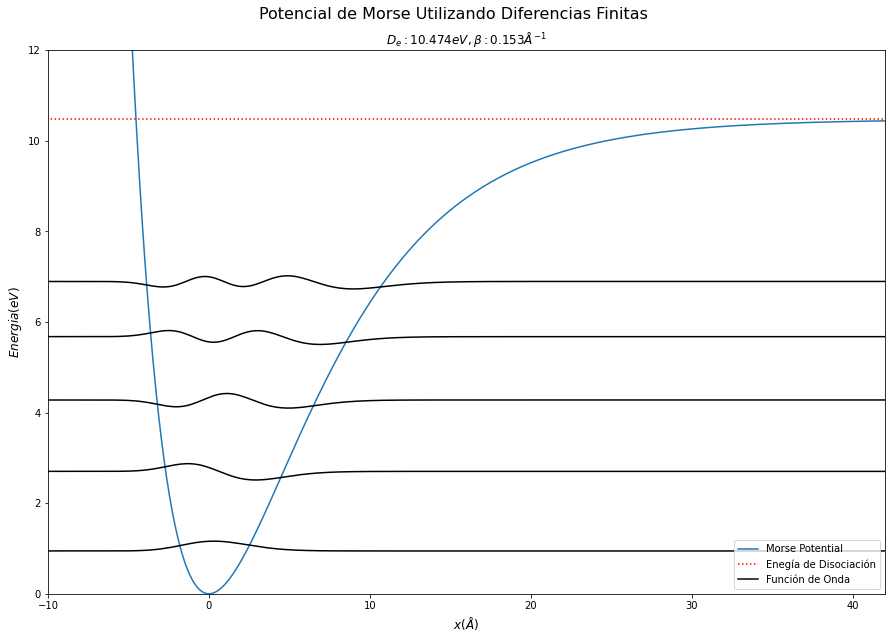

In [168]:
fig = plt.figure(figsize=(15,10))
plt.plot(x*a_0A,Z*Ry,label="Morse Potential")
plt.suptitle('Potencial de Morse Utilizando Diferencias Finitas', fontsize=16,y=0.94)
plt.title(r'$D_{e}: 10.474 eV, \beta: 0.153 \AA^{-1}$',y=1,fontsize=12)
plt.axhline(y = Dd/e,xmin=-2, color = 'r', linestyle = ':',label='Enegía de Disociación')
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$Energia(eV)$',fontsize=12)
plt.plot(x*a_0A,eigenfunctionsmp[:,0]+eigenenergiesmp[0]*Ry,'k',label="Función de Onda")
plt.legend(loc='lower right')
for i in range(1,5):
    plt.plot(x*a_0A,(-1)**(i%2)*eigenfunctionsmp[:,i]+eigenenergiesmp[i]*Ry,'k')

plt.ylim(0,12)
plt.xlim(-10,42)
plt.show() 
plt.show()

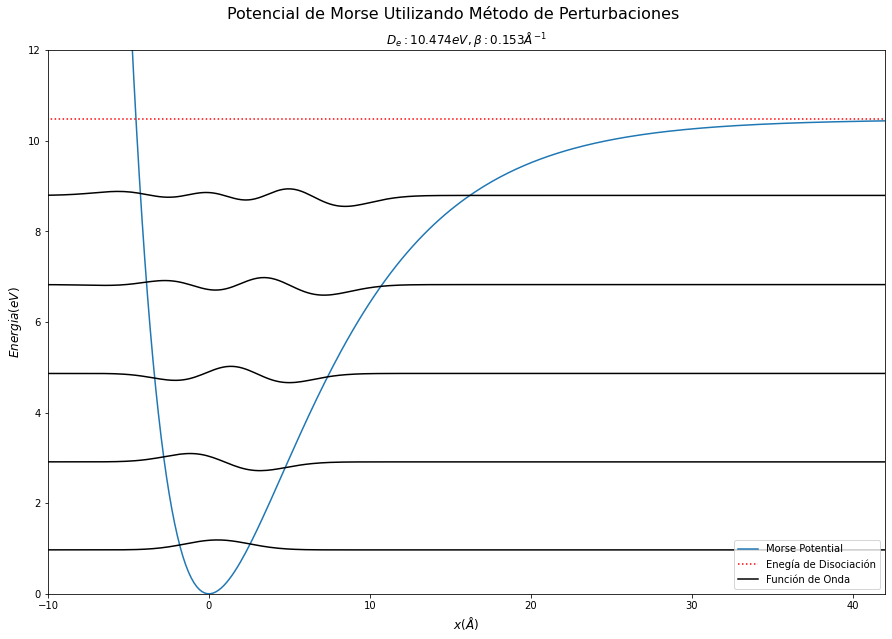

In [165]:
fig = plt.figure(figsize=(15,10))
plt.plot(x*a_0A,Z*Ry,label="Morse Potential")
plt.suptitle('Potencial de Morse Utilizando Método de Perturbaciones', fontsize=16,y=0.94)
plt.title(r'$D_{e}: 10.474 eV, \beta: 0.153 \AA^{-1}$',y=1,fontsize=12)
plt.axhline(y = Dd/e,xmin=-2, color = 'r', linestyle = ':',label='Enegía de Disociación')
plt.xlabel(r'$x (\AA)$', fontsize=12)
plt.ylabel(r'$Energia(eV)$',fontsize=12)
plt.plot(x*a_0A+0.5,psicorrection(x,0,100)+Energies[0],'k',label="Función de Onda")
plt.plot(1.1*x*a_0A+0.9,psicorrection(x,1,100)+Energies[1],'k')
plt.plot(1.15*x*a_0A+1.2,psicorrection(x,2,100)+Energies[2],'k')
plt.plot(1.3*x*a_0A+1.6,psicorrection(x,3,100)+Energies[3],'k')
plt.plot(1.3*x*a_0A+1.9,psicorrection(x,4,100)+Energies[4],'k')
plt.ylim(0,12)
plt.xlim(-10,42)
plt.legend(loc='lower right')
plt.show() 